In [1]:
import os
import data
import model
import utils
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pprint import pprint


In [ ]:
os.system('rm -rf graphs checkpoints')
    

In [62]:
data.load()
os.system('rm -rf graphs checkpoints')
hyper_params = {
    'num_features': 1600,
    'num_hiddens_fc': [1000], 
    'num_classes': 10,
    'learning_rate': 3e-3
}

In [63]:
tf.reset_default_graph()
graph, model_vars = model.create_graph(hyper_params)

In [64]:
train_params = {
    'batch_size' : 128,
    'skip_step' : 1000,
    'n_epochs' : 10000000
}

with tf.Session(graph=graph) as sess:
    # Mot vai thu tuc
    tf.global_variables_initializer().run()
    writer = tf.summary.FileWriter('./graphs/', sess.graph)
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state('./checkpoints/')
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
    
    # Mot vai variable
    initial_step = model_vars['global_step'].eval()
    num_train, num_test = data.stats()
    print('num_train', num_train, 
          'num_test', num_test, 
          'n_batch',int(train_params['n_epochs'] * num_train/train_params['batch_size']), 
          'batch_per_epochs', int(num_train/train_params['batch_size']))
    train_batch = data.train_batch_generator(train_params['batch_size'])

    # Training
    for i in range(initial_step,  int(train_params['n_epochs'] * num_train/train_params['batch_size'])):
        X_batch, Y_batch = next(train_batch)
        feed = {
            model_vars['X']: X_batch,
            model_vars['Y']: Y_batch
        }
        batch_cost, _, summary = sess.run([model_vars['cost'], 
                                                      model_vars['optimizer'], 
                                                      model_vars['summary_op']], feed)
        writer.add_summary(summary, global_step=i)

        if i % train_params['skip_step'] == 0:
            print('batch', i, 'cost', batch_cost)
            saver.save(sess, './checkpoints/', i)


num_train 18945 num_test 4737 n_batch 1480078125 batch_per_epochs 148
batch 0 cost 6.8174
batch 1000 cost 0.280032
batch 2000 cost 0.222386
batch 3000 cost 0.206101
batch 4000 cost 0.155604
batch 5000 cost 0.119799
batch 6000 cost 0.178126
batch 7000 cost 0.0832967
batch 8000 cost 0.0876746
batch 9000 cost 0.136943
batch 10000 cost 0.226475


KeyboardInterrupt: 

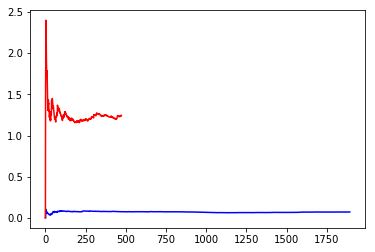

In [61]:
# Learning curve
train_params = {
    'batch_size' : 10,
    'skip_step' : 5,
    'n_epochs' : 1
}
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter('./graphs', sess.graph)    
    
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state('./checkpoints/')
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        
    train_curve = []
    test_curve = []

    train_batch = data.train_batch_generator(train_params['batch_size'])
    test_batch = data.test_batch_generator(train_params['batch_size'])
    num_train, num_test = data.stats()

    cur_num = cur_cost = avg_cost = 0
    for i in range(int(num_train / train_params['batch_size'])):
        X_batch, Y_batch = next(train_batch)
        feed = {
            model_vars['X']: X_batch,
            model_vars['Y']: Y_batch,
        }
        cur_cost = sess.run(model_vars['cost'], feed)
        avg_cost = (avg_cost * cur_num + cur_cost * train_params['batch_size']) / (cur_num + train_params['batch_size'])
        cur_num += train_params['batch_size']
        train_curve.append(avg_cost)

        if i % 10 == 0:
            clear_output()
            plt.plot(train_curve, '-b')
            plt.plot(test_curve, '-r')
            plt.show()

    cur_num = cur_cost = avg_cost = 0
    
    for i in range(int(num_test / train_params['batch_size'])):
        X_batch, Y_batch = next(test_batch)
        feed = {
            model_vars['X']: X_batch,
            model_vars['Y']: Y_batch,
        }
        cur_cost = sess.run(model_vars['cost'], feed)
        avg_cost = (avg_cost * cur_num + cur_cost * train_params['batch_size']) / (cur_num + train_params['batch_size'])
        cur_num += train_params['batch_size']
        test_curve.append(avg_cost)

        
        if i % 10 == 0:
            clear_output()
            plt.plot(train_curve, '-b')
            plt.plot(test_curve, '-r')
            plt.show()

    clear_output()
    plt.plot(train_curve, '-b')
    plt.plot(test_curve, '-r')
    plt.show()

In [60]:
# Learning curve
train_params = {
    'batch_size' : 10,
    'skip_step' : 5,
    'n_epochs' : 1
}
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter('./graphs', sess.graph)    
    
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state('./checkpoints/')
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        
    train_batch = data.train_batch_generator(train_params['batch_size'])
    test_batch = data.test_batch_generator(train_params['batch_size'])
    num_train, num_test = data.stats()
    train_count = test_count = 0

    for i in range(int(num_train / train_params['batch_size'])):
        X_batch, Y_batch = next(train_batch)
        feed = {
            model_vars['X']: X_batch,
            model_vars['Y']: Y_batch
        }
        logits = sess.run(model_vars['logits'], feed)
        train_count += np.sum(Y_batch == np.argmax(logits, axis=1))
    print('[+] Train accuracy:', train_count/float(num_train))

        
        ++    for i in range(int(num_test / train_params['batch_size'])):
        X_batch, Y_batch = next(test_batch)
        feed = {
            model_vars['X']: X_batch,
            model_vars['Y']: Y_batch
        }
        logits = sess.run(model_vars['logits'], feed)
        test_count += np.sum(Y_batch == np.argmax(logits, axis=1))
    print('[+] Test accuracy:', test_count/float(num_test))
    
    

INFO:tensorflow:Restoring parameters from ./checkpoints/-14000
[+] Train accuracy: 0.975560833993
[+] Test accuracy: 0.852438252058
